<h1>Neural Network</h1>

### Loading Essential Dependencies

In this section, we load all the necessary dependencies that will be used throughout the implementation. Each of them will be explained in context as they are utilized.

Although we store the dataset as a `pandas.Dataframe`, the current version of the code does not explicitly require pandas. This is because the dataset is loaded directly from scikit-learn rather than being imported from an external source.

In [ ]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
from tqdm import tqdm

We are importing famous Iris (by R. Fisher 1936) dataset from Scikit learn library. Then setting up random seed which will be used for splitting dataset to train and test split. To be able to load `X` and `y` separately and recieve data as `pandas.Dataframe` we set the function parameters as <b>True</b>

In [117]:
#rand_seed = 40
rand_seed = 21

X,y = load_iris(return_X_y=True, as_frame=True)

Next we split and shuffle the dataset so that we have variables that will be used separately for training and testing of our models. For that we use widely used function from `sklearn.model_selection`. For achieving same results over and over we directly set `random_state=` to specific integer (seed we initialized below). 

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.25, random_state=rand_seed)

It is important to scale our dataset in order to achieve better results. Scaling is achieved by `scaler` which is a instance of `MinMaxScaler` object from `sklearn.preprocessing` library. The MinMaxScaler (in these settings) scales data by dividing each element by the largest number in column. It also returns scaled data as `numpy.ndarray`.

It is important to view train and test dataset as two unrelated sets of data. Model shouldn't have access to information about testing data in training phase, therefore we normalize data after splitting it (not before) sp that these two sets do not influence each other.

In [123]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
type(X_train)

numpy.ndarray

Next we define the model, we inherit from `nn.Module` class which serves as a template for our models in Pytorch. Model's constructor receives `in_features=4` the dimension of input vectors and `out_features=3`. Next we define 2 fully connected Linear layers. Our model thus has input_layer with 4 neurons hidden layer with 30 neurons and output layer with 3 neurons. Output of hidden layer is passed through ReLU (Rectified linear unit) function which is a function that introduces non-linearity to the model (as the linear layer combined will never form non-linear transformation)

The way the network works with the input (also known as the forward pass) is defined in `forward` function which is internally called by the `__call__` function which is inherited from nn.Module parent. 

In [ ]:
class Model(nn.Module):
    def __init__(self, in_features=4, out_features=3):
        super().__init__()
        self.fc1 = nn.Linear(in_features,30)
        self.fc2 = nn.Linear(30,out_features)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x 

Consequently we create the instance of a Model object and other necessary objects for the model's training. Criterion is the loss function, in this case we use `CrossEntropyLoss` which is useful when comparing distributions, other frequently used loss function (for regression problems) is Mean Square Error. But there is a huge number of available loss functions. 

Then we define number of epochs which states number of iterations the training loop goes through, in more complex scenarios we may also implement mechanisms such as early stopping to reduce number of epochs (as the training gets more time and money consuming). 

Afterwards we define opimizer Adam which is currently one of the most used optimizing tools combining adaptive learning rate for each parameter (weight or bias) that is being trained and also momentum mechanism that aims to achieve best results the fastest way (more may be found in paper where Adam wass published: Adam: A Method for Stochastic Optimization by Diederik P. Kingma and Jimmy Ba)

`losses` container will be storing loss function values throughout the training and let us plot the improvement in optimizing after the training phase.

In [31]:
model = Model()
criterion = nn.CrossEntropyLoss()
optimizer = Adam(lr=0.01, params=model.parameters())
epochs = 400
losses = []

When working with Pytorch it is important to work with tensors therefore we create new the variables as tenstors of the data, but we also keep the old variables `X_train` and `y_train` as np.array because we will be using them later outside the Pytorch module.

In [ ]:
X_train_tensor = torch.as_tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.as_tensor(y_train.values, dtype=torch.long).squeeze()

numpy.ndarray

#### Training
Training consists of predicting values output by the model, the prediction is then compared to actual values that were expected (the `y_train` vector) and their difference is measured by `criterion` (the loss function). (Loss is appended to losses container but that does not have any influence on learning we just store the value) Afterwards we reset the gradient values so they can be calculated again based on loss in backward propagation, afterwards we alter the model parameters with optimizer that steps (shifts every parameter accordingly) and the loop goes on. As we can se epochs gives us number of steps we are willing to do in order to converge close to the "best/ideal" values, `learning_rate` on the other hand gives us (or more precisely gives the optimizer) cap for maxmimum step length. 

`tqdm` object creates loading bar below so we know how fast is the model trained.

In [33]:
for ep in tqdm(range(epochs)):
    model.train()
    ypred = model(X_train_tensor)
    loss = criterion(ypred, y_train_tensor)
    losses.append(loss.detach().numpy())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

100%|██████████| 400/400 [00:00<00:00, 1022.48it/s]


Next we plot the loss function development over training epochs.

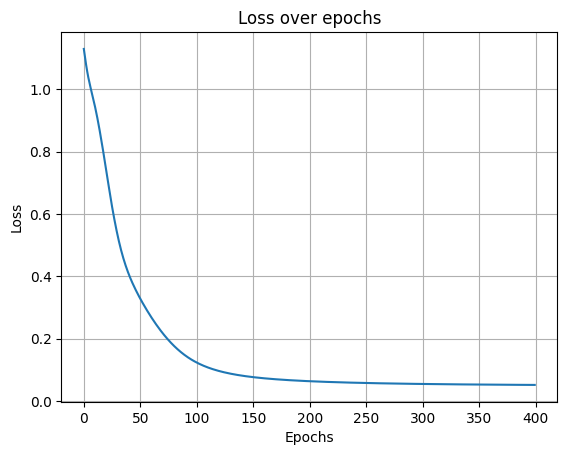

In [34]:
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.plot(losses)
plt.show()

Next we move to testing phase. Firstly we make the necessary preprocessing on the testing set.

In [137]:
scaler = MinMaxScaler()
X_test = scaler.fit_transform(X_test)

In [36]:
X_test_tensor = torch.as_tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.as_tensor(y_test.values, dtype=torch.long).squeeze()

Testing happens in evaluation mode so that the model doesn't learn in this process and just provides results.

In [37]:
correct = 0
incorrect = 0

with torch.no_grad():
    model.eval()
    yhat = model(X_test_tensor)
    
    for row in range(len(y_test_tensor)):
        if torch.argmax(yhat[row]) == y_test_tensor[row]:
            correct += 1
        else:
            incorrect += 1

print(f'correct predictions: {correct}\nincorrect:{incorrect}')

correct predictions: 38
incorrect:0


## K nearest neighbors

K Nearest Neighbors in simple supervised clustering (machine learning) algorithm. It classifies data based on comparing unknows data point to its k closest neighbors (closest points in given metric). K should usually be number that is not divisible by number of classes as it may create unclear results (even though built-in classifiers are able to deal with such problems).

In [38]:
from sklearn.neighbors import KNeighborsClassifier

Let's see our data again

In [39]:
X.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [47]:
sepal_len = X['sepal length (cm)'].values 
sepal_wid = X['sepal width (cm)'].values 
petal_len = X['petal length (cm)'].values 
petal_wid = X['petal width (cm)'].values 

In [49]:
setosa = y == 0
versi = y == 1
virgi = y == 2
virgi

0      False
1      False
2      False
3      False
4      False
       ...  
145     True
146     True
147     True
148     True
149     True
Name: target, Length: 150, dtype: bool

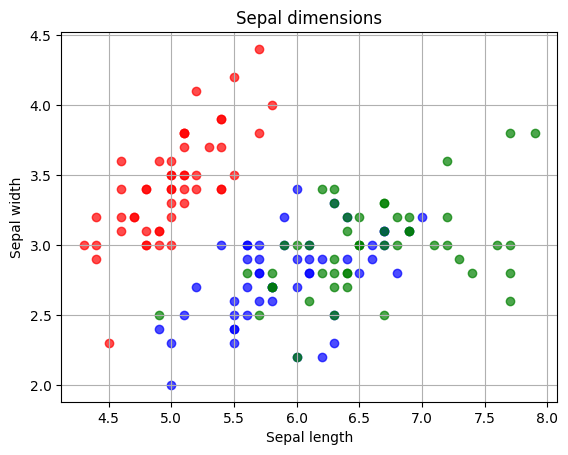

In [50]:
plt.title('Sepal dimensions')
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

plt.scatter(sepal_len[setosa], sepal_wid[setosa], color='red', label='Setosa', alpha=0.7)
plt.scatter(sepal_len[versi], sepal_wid[versi], color='blue', label='Versicolor', alpha=0.7)
plt.scatter(sepal_len[virgi], sepal_wid[virgi], color='green', label='Virginica', alpha=0.7)
plt.grid(True)
plt.show()

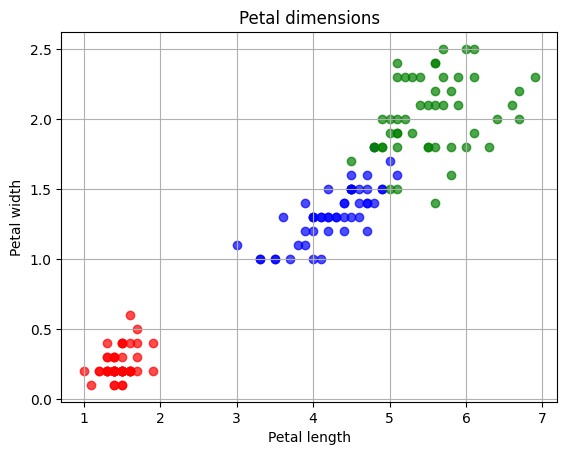

In [51]:
plt.title('Petal dimensions')
plt.xlabel('Petal length')
plt.ylabel('Petal width')

plt.scatter(petal_len[setosa],petal_wid[setosa], color='red', label='Setosa', alpha=0.7)
plt.scatter(petal_len[versi], petal_wid[versi], color='blue', label='Versicolor', alpha=0.7)
plt.scatter(petal_len[virgi], petal_wid[virgi], color='green', label='Virginica', alpha=0.7)
plt.grid(True)
plt.show()

From graphs we can see that if we tried to classify using only Petal or sepal dimensions separately we may achieve very good results for Setosa flower (as it is separated ) but for the best results we will utilize the entire dataset.

In [140]:
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4)

In [141]:
knn_pred = knn.predict(X_test)
sum(knn_pred == y_test)/len(ypred)

0.9736842105263158

Just to visualize the `k` parameter following code plots the precision over different values of `k`. Sudden fall of precision in the end is natural as we have three equall classes and for high values of `k` the two other classes outnumber the smaller number of points in third class and model can never guess right.

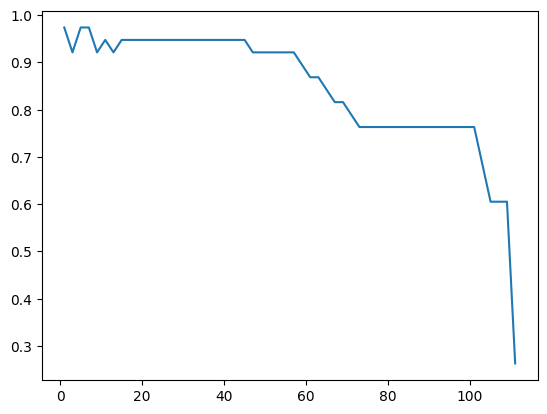

In [142]:
# lets look under the lid
prec = {}
for i in range(1,len(X_train),2):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    ypred = knn.predict(X_test)
    prec[i] = sum(ypred == y_test)/len(ypred)

plt.plot(prec.keys(), prec.values())
plt.show()

<h1>Decision Trees</h1>

Next we can try classiffying data using a decision tree. DT is a nonparametric machine learning algorithm finding best splits in data using entropy.

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [93]:
from sklearn import tree

As we did in kNN we import and fit the object on training data. We are once again dealing with a Supervised learning algorithm so the labels (stored in vector y_train) are now required.

In [103]:
dectree = tree.DecisionTreeClassifier()
dectree.fit(X_train,y_train)

DecisionTreeClassifier()

Next we evaluate.

In [ ]:
tree_pred = dectree.predict(X_test)
sum(tree_pred==y_test)/len(y_test)

1.0

## K-means

Clustering is also possible via Unsupervised approaches, one of which is k-means. In k-means we calculate 'k' centroids (or means) iteratively by calculating mean values of feature vectors of nearest points to the centroid's current value. In the end the points nearest to the centroid are labeled as one class.

In [94]:
from sklearn.cluster import KMeans

In [97]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(X_train)

c:\Users\Dodo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=3)

In [ ]:
kmeans_predict = kmeans.predict(X_test)
# important to understand the output of kmeans -- predict == y_test will not work now
# looking at results it may seem that classes 0 and 1 are swapped therefore
# as we already know the correct classes and we are using kmeans as a demonstration 
# we can simply alter the class labels and evalueate as before

for c in range(len(kmeans_predict)):
    if kmeans_predict[c] == 2:
        continue
    elif kmeans_predict[c] == 0:
        kmeans_predict[c] = 1
    elif kmeans_predict[c] == 1:
        kmeans_predict[c] = 0

sum(kmeans_predict == y_test)/len(y_test)

0.9473684210526315

<b>In the end it is important to clarify that such good results (seamingly easily acquired) are due to small number of data in dataset, if our dataset consisted of higher hundreds of datapoints we would be able to better train and test our models. Contrary dealing with only 150 data points while testing with 38 of them we may achieve high precision but if given testing dateset of length 200 we'll be able to see more telling results</b>